# GBX model on WSMD


In [6]:
from google.colab import drive
drive.mount('/content/drive')

# Requirements to Run the Notebook

In [7]:
!pip install transformers
!pip install nltk
!pip install gdown

In [13]:
# the OG 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style


# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.utils.class_weight import compute_class_weight

#NLP Specifics
from nltk import word_tokenize
import nltk
from tokenizers import BertWordPieceTokenizer
from transformers import (AdamW,get_linear_schedule_with_warmup,get_cosine_schedule_with_warmup,RobertaTokenizerFast,DistilBertTokenizerFast,PreTrainedTokenizerFast,AutoModel,
                          DistilBertTokenizerFast,GPT2TokenizerFast,AutoTokenizer,BertTokenizer,TFBertModel,TFOpenAIGPTModel,OpenAIGPTTokenizer,DistilBertTokenizer, TFDistilBertModel,XLMTokenizer, TFXLMModel,TFBertForSequenceClassification,TFGPT2Model,TFXLMRobertaModel)

#tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import Constant

#other imports
import urllib
import os
import gc
from tqdm import tqdm
import re
import random
from typing import Callable, List, Optional, Union


nltk.download('punkt')
style.use('ggplot')
MAX_LEN=256

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mohammad.Khan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
def seed_everything(seed):
  random.seed(seed)
  tf.compat.v1.set_random_seed(seed)
  tf.random.set_seed(seed)
seed_everything(123)

In [11]:
def download_data():
    previous_dir=os.getcwd()
    if not os.path.isdir(os.getcwd()+"/WSDM_data"):
        os.mkdir("WSDM_data")
    os.chdir(os.getcwd()+"/WSDM_data")
    !gdown --id 1-3ma4OUj19kwprcmdeZW8eQ6i_5LSFv1 --output test.csv
    !gdown --id 1--7C4t4FCT1279e6Islk51InQgmcanYq --output train.csv
    os.chdir(previous_dir)
download_data()

Downloading...
From: https://drive.google.com/uc?id=1-3ma4OUj19kwprcmdeZW8eQ6i_5LSFv1
To: C:\Users\Mohammad.Khan\Anaconda3\libs\GBX_Model\main\WSDM_data\test.csv

0.00B [00:00, ?B/s]
524kB [00:01, 398kB/s]
1.05MB [00:01, 673kB/s]
1.57MB [00:02, 568kB/s]
2.10MB [00:04, 478kB/s]
2.62MB [00:04, 641kB/s]
3.15MB [00:04, 814kB/s]
3.67MB [00:05, 963kB/s]
4.19MB [00:05, 1.13MB/s]
4.72MB [00:05, 1.18MB/s]
5.24MB [00:06, 1.42MB/s]
5.77MB [00:06, 1.59MB/s]
6.29MB [00:06, 1.71MB/s]
6.82MB [00:06, 1.66MB/s]
7.34MB [00:08, 824kB/s] 
7.86MB [00:08, 1.01MB/s]
8.39MB [00:08, 1.22MB/s]
8.91MB [00:08, 1.45MB/s]
9.44MB [00:09, 1.49MB/s]
9.96MB [00:09, 1.41MB/s]
10.5MB [00:10, 1.36MB/s]
11.0MB [00:10, 1.46MB/s]
11.5MB [00:10, 1.57MB/s]
12.1MB [00:10, 1.73MB/s]
12.6MB [00:11, 1.80MB/s]
13.1MB [00:11, 1.94MB/s]
13.6MB [00:11, 2.05MB/s]
14.2MB [00:12, 1.72MB/s]
14.7MB [00:14, 566kB/s] 
15.2MB [00:18, 275kB/s]
15.7MB [00:20, 297kB/s]
16.3MB [00:20, 402kB/s]
16.8MB [00:21, 431kB/s]
17.3MB [00:24, 281kB/s]
17.8M

In [15]:
df_train=pd.read_csv(os.getcwd()+"/WSDM_data/train.csv")
df_test=pd.read_csv(os.getcwd()+"/WSDM_data/test.csv")

In [16]:
df_train['label'].value_counts()

unrelated    219313
agreed        92973
disagreed      8266
Name: label, dtype: int64

In [17]:
df_train.head()

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
0,0,0,1,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,3,2,3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,1,2,4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,2,2,5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated
4,9,6,7,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,agreed


In [18]:
df_test.head()

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en
0,321187,167562,59521,萨拉赫人气爆棚!埃及总统大选未参选获百万选票 现任总统压力山大,辟谣！里昂官方否认费基尔加盟利物浦，难道是价格没谈拢？,egypt 's presidential election failed to win m...,Lyon! Lyon officials have denied that Felipe F...
1,321190,167564,91315,萨达姆被捕后告诫美国的一句话，发人深思,10大最让美国人相信的荒诞谣言，如蜥蜴人掌控着美国,A message from Saddam Hussein after he was cap...,The Top 10 Americans believe that the Lizard M...
2,321189,167563,167564,萨达姆此项计划没有此国破坏的话，美国还会对伊拉克发动战争吗,萨达姆被捕后告诫美国的一句话，发人深思,Will the United States wage war on Iraq withou...,A message from Saddam Hussein after he was cap...
3,321193,167564,160994,萨达姆被捕后告诫美国的一句话，发人深思,被绞刑处死的萨达姆是替身？他的此男人举动击破替身谣言！,A message from Saddam Hussein after he was cap...,The hanging Saddam is a surrogate? This man's ...
4,321191,167564,15084,萨达姆被捕后告诫美国的一句话，发人深思,中国川贝枇杷膏在美国受到热捧？纯属谣言！,A message from Saddam Hussein after he was cap...,Chinese loquat loquat plaster in America? Pure...


In [19]:
df_train.drop(['id','tid1','tid2','title1_zh','title2_zh'],inplace=True,axis=1)

In [20]:
df_train,df_valid=train_test_split(df_train,stratify=df_train['label'],test_size=0.2)

<AxesSubplot:>

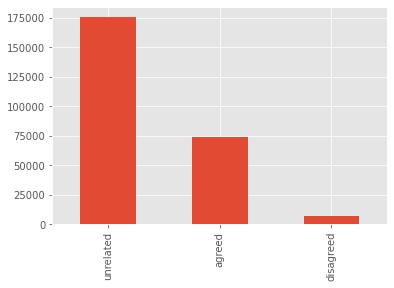

In [21]:
df_train['label'].value_counts().plot(kind='bar')

<AxesSubplot:>

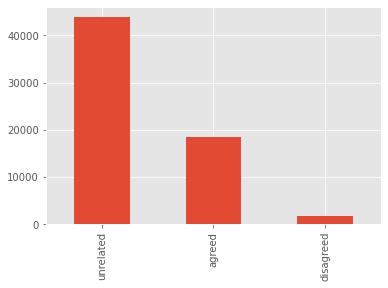

In [22]:
df_valid['label'].value_counts().plot(kind='bar')

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.24.218.98:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.24.218.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.24.218.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [23]:
def fast_tokenization(text,encode_plus=False):
  attention_mask=[]
  input_ids=[]
  for instance in tqdm(text,desc='Tokenization Process'):
    if encode_plus:
      token_out=fast_tokenizer.encode_plus(instance,return_attention_mask=True,padding='max_length',truncation=True,max_length=MAX_LEN)
      input_ids.append(token_out['input_ids'])
      attention_mask.append(token_out['attention_mask'])
    else:
      token_out=fast_tokenizer.encode(instance)
      input_ids.append(token_out.ids)
      attention_mask.append(token_out.attention_mask)
  return input_ids,attention_mask

In [24]:
X_train={}
X_valid={}
X_test={}

In [25]:
def stop_word_removal(text):
  stop_word=['The','the','a','A','An','an']
  tokenized_sentence=word_tokenize(text)
  final_tokenized_sentence=[]
  for word in tokenized_sentence:
    if word not in stop_word:
        final_tokenized_sentence.append(word)
  final_tokenized_sentence=' '.join(final_tokenized_sentence)
  return final_tokenized_sentence

In [26]:
df_train.isnull().sum()

title1_en    0
title2_en    0
label        0
dtype: int64

In [27]:
df_valid.isnull().sum()

title1_en    0
title2_en    0
label        0
dtype: int64

In [28]:
df_train.head()

,title1_en,title2_en,label
236411,"Keep a bowl of black sesame every day, make yo...","Can let hair black, change more black sesame, ...",unrelated
272649,"Boys kiss girls at school assemblies, can you ...",A schoolboy trips a girl to his death?,unrelated
115896,"In a pity mine accident, do not buy the card o...",The official denial of the main chain of bifur...,unrelated
119247,Eating eggs is smoking.,Eating eggs like this is equivalent to swallow...,unrelated
134789,"in summer, i 'll get a tan. how can i come bac...","Whitening tips, learn three days than toilet p...",agreed


In [29]:
df_train['combine_text_tokenize']=df_train['title1_en']+' '+df_train['title2_en']
df_valid['combine_text_tokenize']=df_valid['title1_en']+' '+df_valid['title2_en']
df_test['combine_text_tokenize']=df_test['title1_en']+' '+df_test['title2_en']

In [30]:
df_train.iloc[11500,-1]

"female anchorwoman spends the night at the national palace museum to make a live show, the national palace museum official issued a statement on the investigation. Usho's second-hand vehicle issued a statement to clarify rumors about the source of the car."

In [31]:
df_train['combine_text_tokenize']=df_train['combine_text_tokenize'].map(stop_word_removal)
df_valid['combine_text_tokenize']=df_valid['combine_text_tokenize'].map(stop_word_removal)
df_test['combine_text_tokenize']=df_test['combine_text_tokenize'].map(stop_word_removal)

In [32]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Applies a warmup schedule on a given learning rate decay schedule.

    Args:
        initial_learning_rate (:obj:`float`):
            The initial learning rate for the schedule after the warmup (so this will be the learning rate at the end
            of the warmup).
        decay_schedule_fn (:obj:`Callable`):
            The schedule function to apply after the warmup for the rest of training.
        warmup_steps (:obj:`int`):
            The number of steps for the warmup part of training.
        power (:obj:`float`, `optional`, defaults to 1):
            The power to use for the polynomial warmup (defaults is a linear warmup).
        name (:obj:`str`, `optional`):
            Optional name prefix for the returned tensors during the schedule.
    """

    def __init__(
        self,
        initial_learning_rate: float,
        decay_schedule_fn: Callable,
        warmup_steps: int,
        power: float = 1.0,
        name: str = None,
    ):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.power = power
        self.decay_schedule_fn = decay_schedule_fn
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "WarmUp") as name:

            global_step_float = tf.cast(step, tf.float32)
            warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
            warmup_percent_done = global_step_float / warmup_steps_float
            warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
            return tf.cond(
                global_step_float < warmup_steps_float,
                lambda: warmup_learning_rate,
                lambda: self.decay_schedule_fn(step - self.warmup_steps),
                name=name,
            )

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_schedule_fn": self.decay_schedule_fn,
            "warmup_steps": self.warmup_steps,
            "power": self.power,
            "name": self.name,
        }



def create_optimizer(
    init_lr: float,
    num_train_steps: int,
    num_warmup_steps: int,
    min_lr_ratio: float = 0.0,
    adam_epsilon: float = 1e-8,
    weight_decay_rate: float = 0.0,
    include_in_weight_decay: Optional[List[str]] = None,schedule='linear',
):
    """
    Creates an optimizer with a learning rate schedule using a warmup phase followed by a linear decay.

    Args:
        init_lr (:obj:`float`):
            The desired learning rate at the end of the warmup phase.
        num_train_step (:obj:`int`):
            The total number of training steps.
        num_warmup_steps (:obj:`int`):
            The number of warmup steps.
        min_lr_ratio (:obj:`float`, `optional`, defaults to 0):
            The final learning rate at the end of the linear decay will be :obj:`init_lr * min_lr_ratio`.
        adam_epsilon (:obj:`float`, `optional`, defaults to 1e-8):
            The epsilon to use in Adam.
        weight_decay_rate (:obj:`float`, `optional`, defaults to 0):
            The weight decay to use.
        include_in_weight_decay (:obj:`List[str]`, `optional`):
            List of the parameter names (or re patterns) to apply weight decay to. If none is passed, weight decay is
            applied to all parameters except bias and layer norm parameters.
    """
    # Implements linear decay of the learning rate.
    if schedule=='linear':
      lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
          initial_learning_rate=init_lr,
          decay_steps=num_train_steps - num_warmup_steps,
          end_learning_rate=init_lr * min_lr_ratio,
      )
    else:
      lr_schedule=tf.keras.experimental.CosineDecay(
      initial_learning_rate=init_lr, decay_steps=num_train_steps - num_warmup_steps, alpha=0.0, name=None)
      
    if num_warmup_steps:
        lr_schedule = WarmUp(
            initial_learning_rate=init_lr, decay_schedule_fn=lr_schedule, warmup_steps=num_warmup_steps,
        )
    if weight_decay_rate > 0.0:
        optimizer = AdamWeightDecay(
            learning_rate=lr_schedule,
            weight_decay_rate=weight_decay_rate,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=adam_epsilon,
            exclude_from_weight_decay=["LayerNorm", "layer_norm", "bias"],
            include_in_weight_decay=include_in_weight_decay,
        )
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=adam_epsilon)
    # We return the optimizer and the LR scheduler in order to better track the
    # evolution of the LR independently of the optimizer.
    return optimizer, lr_schedule

In [33]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [34]:
def accuracy(y_true,y_pred,name):
  y_true=np.argmax(y_true,axis=1)
  y_pred=np.argmax(y_pred,axis=1)
  accuracy=accuracy_score(y_true,y_pred)
  print('The accuracy of the model {} is Accuracy: {:.3%}'.format(name,accuracy))
  print(classification_report(y_true, y_pred, target_names=['unrelated','agreed','disagreed']))

In [35]:
def f1_score_m(y_true,y_pred,name):
  y_true=np.argmax(y_true,axis=1)
  y_pred=np.argmax(y_pred,axis=1)
  f1_m=f1_score(y_true,y_pred,average='macro')
  print('The F1-M Score of the model {} is F-1-Score: {:.3%}'.format(name,f1_m))

In [36]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history,main_title):
# Use a log scale to show the wide range of values.
    plt.figure(figsize=(12,10))
    plt.semilogy(list(range(len(history))),  history,
               color='blue', label='Training')
    plt.title(main_title)
    plt.xlabel('Logging Step')
    plt.ylabel('Loss')
  
    plt.legend(title="Log Loss")
    
    
def plot_cm(y_true, y_pred, title):
    ''''
    input y_true-Ground Truth Labels
          y_pred-Predicted Value of Model
          title-What Title to give to the confusion matrix
    
    Draws a Confusion Matrix for better understanding of how the model is working
    
    return None
    
    '''
    
    figsize=(10,10)
    y_true=np.argmax(y_true,axis=1)
    y_pred=np.argmax(y_pred,axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [37]:
true_labels=['true','half-true','barely-true','mostly-true']
false_labels=['false','pants-fire']
high_score_labels=[]

def score_submission(gold_labels, test_labels):
    score = 0.0
    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance in high_score_labels:
                score += 0.50
        if g_stance in true_labels and t_stance in true_labels:
            score += 0.1
        elif g_stance in false_labels and t_stance in false_labels:
            score += 0.1
        

    return score

def report_score(actual,predicted,name):
    actual=np.argmax(actual,axis=1)
    predicted=np.argmax(predicted,axis=1)
    score = score_submission(actual,predicted)
    best_score = score_submission(actual,actual)
    print('For Model {}'.format(name))
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score

In [38]:
def tensorflow_make_train_valid_data(X_train,y_train,X_valid,y_valid,test=False):

      train = (
          tf.data.Dataset
          .from_tensor_slices((X_train, y_train))
          .repeat()
          .shuffle(1024)
          .batch(BATCH_SIZE)
          .prefetch(AUTO))

      valid = (
          tf.data.Dataset
          .from_tensor_slices((X_valid, y_valid))
          .batch(BATCH_SIZE)
          .cache()
          .prefetch(AUTO)
      )
      return train,valid

In [39]:
def make_test_data(X_test):
    test = (
          tf.data.Dataset
          .from_tensor_slices(X_test)
          .batch(BATCH_SIZE)
      )
    return test

In [40]:
fast_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")._tokenizer
fast_tokenizer.enable_padding(length=MAX_LEN)
fast_tokenizer.enable_truncation(max_length=MAX_LEN)


input_ids_distill_bert,attention_mask_distill_bert=fast_tokenization(df_train['combine_text_tokenize'].values)
X_train['input_ids_distill_bert'],X_train['attention_mask_distill_bert']=input_ids_distill_bert,attention_mask_distill_bert
del input_ids_distill_bert
del attention_mask_distill_bert
gc.collect()
input_ids_distill_bert,attention_mask_distill_bert=fast_tokenization(df_valid['combine_text_tokenize'].values)
X_valid['input_ids_distill_bert'],X_valid['attention_mask_distill_bert']=input_ids_distill_bert,attention_mask_distill_bert
del input_ids_distill_bert
del attention_mask_distill_bert
gc.collect()
input_ids_distill_bert,attention_mask_distill_bert=fast_tokenization(df_test['combine_text_tokenize'].values)

X_test['input_ids_distill_bert'],X_test['attention_mask_distill_bert']=input_ids_distill_bert,attention_mask_distill_bert
del input_ids_distill_bert
del attention_mask_distill_bert
gc.collect()

Tokenization Process: 100%|██████████| 80126/80126 [00:13<00:00, 5740.13it/s]


26

In [41]:
fast_tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")._tokenizer
fast_tokenizer.enable_padding(length=MAX_LEN)
fast_tokenizer.enable_truncation(max_length=MAX_LEN)

input_ids_gpt_2,attention_mask_gpt_2=fast_tokenization(df_train['combine_text_tokenize'].values)


X_train['input_ids_gpt_2'],X_train['attention_mask_gpt_2']=input_ids_gpt_2,attention_mask_gpt_2
del input_ids_gpt_2
del attention_mask_gpt_2
gc.collect()
input_ids_gpt_2,attention_mask_gpt_2=fast_tokenization(df_valid['combine_text_tokenize'].values)
X_valid['input_ids_gpt_2'],X_valid['attention_mask_gpt_2']=input_ids_gpt_2,attention_mask_gpt_2
del input_ids_gpt_2
del attention_mask_gpt_2
gc.collect()
input_ids_gpt_2,attention_mask_gpt_2=fast_tokenization(df_test['combine_text_tokenize'].values)
X_test['input_ids_gpt_2'],X_test['attention_mask_gpt_2']=input_ids_gpt_2,attention_mask_gpt_2
del input_ids_gpt_2
del attention_mask_gpt_2
gc.collect()

Tokenization Process: 100%|██████████| 80126/80126 [00:14<00:00, 5433.34it/s]


26

In [42]:
model_type = 'distilroberta-base'
fast_tokenizer =AutoTokenizer.from_pretrained(model_type)
roberta_model_base_input_id,roberta_model_attention_mask=fast_tokenization(df_train['combine_text_tokenize'].values,encode_plus=True)
X_train['input_ids_roberta'],X_train['attention_mask_roberta']=roberta_model_base_input_id,roberta_model_attention_mask
del roberta_model_base_input_id
del roberta_model_attention_mask
gc.collect()
roberta_model_base_input_id,roberta_model_attention_mask=fast_tokenization(df_valid['combine_text_tokenize'].values,encode_plus=True)
X_valid['input_ids_roberta'],X_valid['attention_mask_roberta']=roberta_model_base_input_id,roberta_model_attention_mask
del roberta_model_base_input_id
del roberta_model_attention_mask
gc.collect()
roberta_model_base_input_id,roberta_model_attention_mask=fast_tokenization(df_test['combine_text_tokenize'].values,encode_plus=True)
X_test['input_ids_roberta'],X_test['attention_mask_roberta']=roberta_model_base_input_id,roberta_model_attention_mask
del roberta_model_base_input_id
del roberta_model_attention_mask
gc.collect()

Tokenization Process: 100%|██████████| 80126/80126 [00:23<00:00, 3391.84it/s]


26

In [43]:
y_train=tf.keras.utils.to_categorical(df_train['label'].map({'unrelated':0,'agreed':1,'disagreed':2}).values)
y_valid=tf.keras.utils.to_categorical(df_valid['label'].map({'unrelated':0,'agreed':1,'disagreed':2}).values)

In [44]:
print(X_train.keys())
print(X_valid.keys())

dict_keys(['input_ids_distill_bert', 'attention_mask_distill_bert', 'input_ids_gpt_2', 'attention_mask_gpt_2', 'input_ids_roberta', 'attention_mask_roberta'])
dict_keys(['input_ids_distill_bert', 'attention_mask_distill_bert', 'input_ids_gpt_2', 'attention_mask_gpt_2', 'input_ids_roberta', 'attention_mask_roberta'])


In [45]:
BATCH_SIZE = 64
EPOCHS=20
LEARNING_RATE=1e-5
BETA_1=0.9
BETA_2=0.999
AUTO = tf.data.experimental.AUTOTUNE
steps_per_epoch=df_train.shape[0]//BATCH_SIZE
total_optimization_steps=int(steps_per_epoch*EPOCHS)
WARM_UP_STEPS=int(0.06*total_optimization_steps)
optimizer_with_schedule,lr_schedule=create_optimizer(init_lr=LEARNING_RATE,num_train_steps=total_optimization_steps,num_warmup_steps=WARM_UP_STEPS,schedule='cosine')
EARLY_STOP=tf.keras.callbacks.EarlyStopping(patience=5)
MAX_LEN=MAX_LEN
LOSS=tf.keras.losses.CategoricalCrossentropy()
OPTIMIZER=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=BETA_1,beta_2=BETA_2)
del df_train
del df_valid
gc.collect()

0

In [ ]:
test=make_test_data(X_test)

In [ ]:
def gbx_layers():
    distill_bert = (
                TFDistilBertModel.from_pretrained('distilbert-base-uncased')
            )
    

    gpt_layer=(
        TFGPT2Model.from_pretrained('distilgpt2')
    )


    roberta_model=(
        TFXLMRobertaModel.from_pretrained('distilroberta-base')
    )




    input_ids_distill_bert = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids_distill_bert")
    attention_mask_distill_bert=tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask_distill_bert")

    input_ids_gpt_2 = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids_gpt_2")
    attention_mask_gpt_2=tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask_gpt_2")

    input_ids_roberta = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids_roberta")
    attention_mask_roberta=tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask_roberta")
        
    
    hidden_state_output_dbert=distill_bert([input_ids_distill_bert,attention_mask_distill_bert])[0]
    hidden_state_output_gpt_2,_=gpt_layer({'input_ids': input_ids_gpt_2, 'attention_mask': attention_mask_gpt_2},past=None)
    hidden_state_output_roberta,_=roberta_model([input_ids_roberta,attention_mask_roberta])
    
    
    
    combine_input_1=tf.keras.layers.concatenate([hidden_state_output_dbert,hidden_state_output_gpt_2,hidden_state_output_roberta],axis=2,name='Concatenate_layer')
    
    final_input=tf.keras.layers.Conv1D(filters=768,kernel_size=3,padding='same',name='Conv_1d_layer')(combine_input_1)
    final_input_1=tf.keras.layers.GlobalAveragePooling1D(name='Average_Pooling_layer')(final_input)
    out = tf.keras.layers.Dense(3, activation='softmax',name='Softmax_Layer')(final_input_1)


    model = tf.keras.Model(inputs=[input_ids_distill_bert,attention_mask_distill_bert,input_ids_gpt_2,attention_mask_gpt_2,input_ids_roberta,attention_mask_roberta], outputs=out)
   
    return model

In [ ]:
def compile_gbx(optim):
  model=gbx_layers()
  model.compile(optimizer=optim,loss=LOSS,metrics='accuracy')
  print(model.summary())
  return model


train,valid=tensorflow_make_train_valid_data(X_train,y_train,X_valid,y_valid)
del X_train,X_valid
gc.collect()
with strategy.scope():
  model=compile_gbx(optimizer_with_schedule)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


All model checkpoint weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Some weights of the model checkpoint at distilroberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the model checkpoint at distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids_distill_bert (InputLa [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask_distill_bert (In [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask_gpt_2 (InputLaye [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_ids_gpt_2 (InputLayer)    [(None, 256)]        0                                            
_______________________________________________________________________________________

## GBX Model Run

Following Parameters were used-Run(1)


1.   BATCH_SIZE = 64
2.   EPOCHS=20(with early callback)
3.   LEARNING_RATE=1e-5
4.   BETA_1=0.9-BETA_2=0.999
5.   Scheduler=Cosine with Intial Learning Rate of 1e-5
6.   Freezing=No Layer was Freezed
7.   MAX_LEN=256
8.   Trained on TPU(Google Colab)
9.   Balanced Wieghts were Used

In [ ]:
history = LossHistory()
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

model.fit(
      train,steps_per_epoch=steps_per_epoch,
      epochs=EPOCHS,callbacks=[history,EARLY_STOP], validation_data=valid,class_weight=d_class_weights
)

Epoch 1/20
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   2/4006 [..............................] - ETA: 8:53 - loss: 1.8326 - accuracy: 0.0234   WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0142s vs `on_train_batch_end` time: 0.2481s). Check your callbacks.


4006/4006 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.6247WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0045s vs `on_test_batch_end` time: 0.0665s). Check your callbacks.


4006/4006 [==============================] - 1124s 280ms/step - loss: 0.6567 - accuracy: 0.6247 - val_loss: 0.5477 - val_accuracy: 0.7515
Epoch 2/20
4006/4006 [==============================] - 1103s 275ms/step - loss: 0.4363 - accuracy: 0.7520 - val_loss: 0.4209 - val_accuracy: 0.8095
Epoch 3/20
4006/4006 [==============================] - 1107s 276ms/step - loss: 0.3270 - accuracy: 0.8030 - val_loss: 0.3997 - val_accuracy: 0.8256
Epoch 4/20
4006/4006 [==============================] - 1105s 276ms/step - loss: 0.2642 - accuracy: 0.8389 - val_loss: 0.4367 - val_accuracy: 0.8283
Epoch 5/20
4006/4006 [==============================] - 1106s 276ms/step - loss: 0.2235 - accuracy: 0.8644 - val_loss: 0.4892 - val_accuracy: 0.8202
Epoch 6/20
4006/4006 [==============================] - 1103s 275ms/step - loss: 0.1932 - accuracy: 0.8839 - val_loss: 0.3609 - val_accuracy: 0.8625
Epoch 7/20
4006/4006 [==============================] - 1105s 276ms/step - loss: 0.1666 - accuracy: 0.9014 - val_loss

## Note
Due to un-availibility of test labels for this latest compeition I had to check metrics performance on validation data but test predicted label were tested on kaggle leaderboard and screen shot is attached for each run

### Kaggle Performance Test Set

In [ ]:
y_pred=model.predict(test,verbose=1)
y_pred=tf.argmax(y_pred,axis=1)
y_pred=pd.Series(y_pred).map({0:'unrelated',1:'agreed',2:'disagreed'})
submission=pd.DataFrame()
submission['category']=y_pred
submission['id']=df_test['id']
submission.to_csv('WSDM_kaggle_test.csv')

   2/1252 [..............................] - ETA: 1:46:11WARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0046s vs `on_predict_batch_end` time: 0.0631s). Check your callbacks.


1252/1252 [==============================] - 97s 77ms/step


In [ ]:
y_pred=model.predict(valid,verbose=1)
y_true=y_valid

   2/1002 [..............................] - ETA: 1:27:20WARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0090s vs `on_predict_batch_end` time: 0.0665s). Check your callbacks.


1002/1002 [==============================] - 94s 94ms/step


In [ ]:
saved_history=np.array(history.losses)
np.save('y_pred_WSDM_run(1).npy',y_pred,allow_pickle=True)
np.save('saved_history_WSDM_run(1).npy',saved_history)

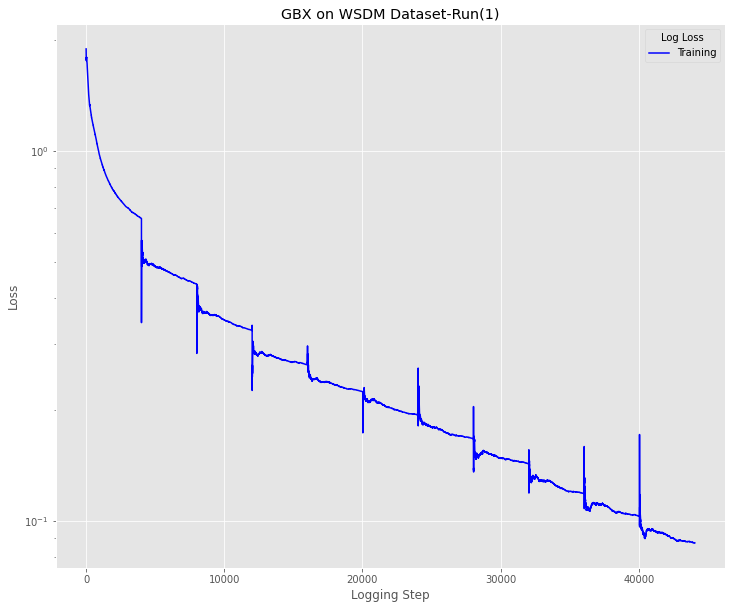

In [ ]:
history=np.load('/content/drive/My Drive/Final Research Project/saved_history_WSDM_run(1).npy',allow_pickle=True)
plot_loss(history,'GBX on WSDM Dataset-Run(1)')

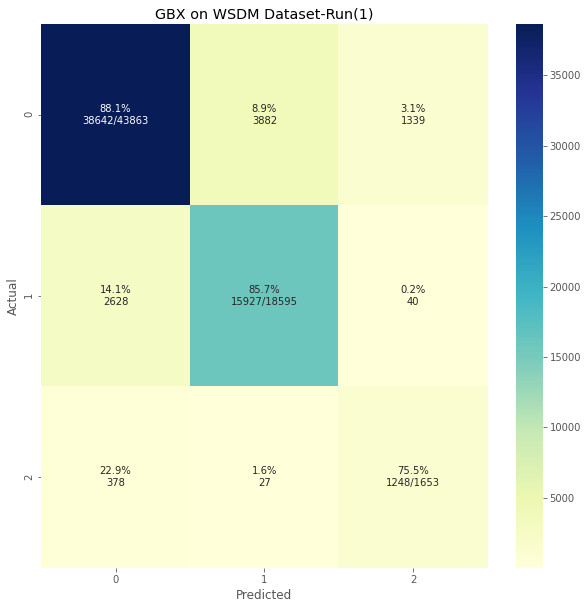

In [ ]:
plot_cm(y_true, y_pred, 'GBX on WSDM Dataset-Run(1)')

In [ ]:
accuracy(y_true,y_pred,'GBX on WSDM Dataset-Run(1)')

The accuracy of the model GBX on WSDM Dataset-Run(1) is Accuracy: 87.063%
              precision    recall  f1-score   support

   unrelated       0.93      0.88      0.90     43863
      agreed       0.80      0.86      0.83     18595
   disagreed       0.48      0.75      0.58      1653

    accuracy                           0.87     64111
   macro avg       0.74      0.83      0.77     64111
weighted avg       0.88      0.87      0.87     64111

